In [10]:

# Load CIFAR-10 dataset without normalization for mean/std computation

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm


def compute_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in dataloader:
        batch_samples = images.size(0)  
        images = images.view(batch_samples, 3, -1) 
        mean += images.mean(dim=[0, 2]) * batch_samples
        std += images.std(dim=[0, 2]) * batch_samples
        total_samples += batch_samples

    mean /= total_samples
    std /= total_samples
    return mean.tolist(), std.tolist()

compute_transform = transforms.Compose([transforms.ToTensor()])
compute_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=compute_transform)
compute_loader = torch.utils.data.DataLoader(compute_dataset, batch_size=10000, shuffle=False)

# Get Mean and Std
mean, std = compute_mean_std(compute_loader)
print(f"Computed Mean: {mean}")
print(f"Computed Std: {std}")

# Define the Corrected Transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)  
])


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)



print(f"Test set size: {len(testset)} images")  


Files already downloaded and verified
Computed Mean: [0.49139946699142456, 0.4821587800979614, 0.4465312957763672]
Computed Std: [0.24702714383602142, 0.2434811145067215, 0.2615843415260315]
Files already downloaded and verified
Test set size: 10000 images


In [11]:
#load model 

from network import SmallAlexNet  
device = torch.device("cpu")

model = SmallAlexNet().to(device)
model.load_state_dict(torch.load("/Users/jaeeponde/trustworthy_ai/model_weight.pt", map_location=device))  # Replace with actual weight file
model.eval() 

/var/folders/29/458ydd_j11q4vpw8md8c37fh0000gn/T/ipykernel_98796/3065424494.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/jaee

SmallAlexNet(
  (conv1): Conv2d(3, 384, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (conv2): Conv2d(384, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12288, out_features=384, bias=True)
  (fc2): Linear(in_features=384, out_features=192, bias=True)
  (fc3): Linear(in_features=192, out_features=10, bias=True)
  (relu): ReLU()
)

In [14]:
mean = torch.tensor([0.4914, 0.4822, 0.4465])  # CIFAR-10 mean
std = torch.tensor([0.2470, 0.2435, 0.2616])   # CIFAR-10 std


Step 0: Loss = 3.126123
Step 100: Loss = 0.042542
Step 200: Loss = 0.034498
Step 300: Loss = 0.032892
Step 400: Loss = 0.032783


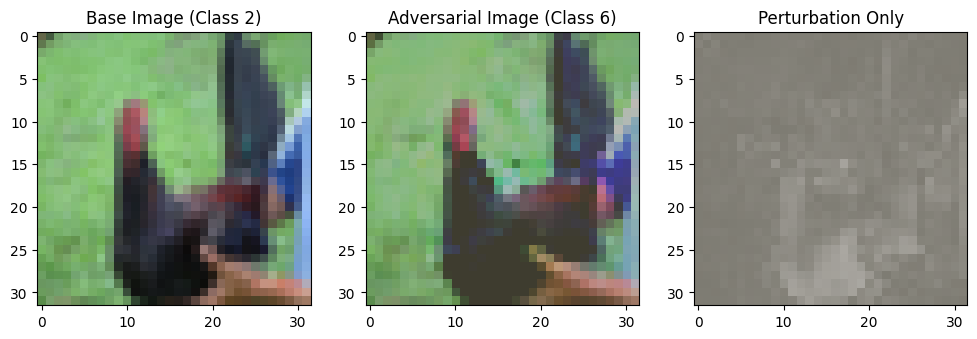

Original Class: 2, New Class: 6


In [15]:


device = torch.device("cpu")


base_idx = 25  #choose random base image
base_image, base_label = testset[base_idx]
target_class = 6  #frog class

# Move image to device and add batch dimension
base_image = base_image.unsqueeze(0).to(device)  
x = base_image.clone().detach().requires_grad_(True)

# Define hyperparameters
beta = 0.6  # Weight for keeping perturbations small
lr = 0.2  # Learning rate
num_steps = 500  # Number of optimization steps
optimizer = torch.optim.Adam([x], lr=lr) #using adam optimisation
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)


with torch.no_grad():
    target_output = torch.zeros((1, 10)).to(device)
    target_output[0, target_class] = 1.0

for step in range(num_steps):
    optimizer.zero_grad()
    
   
    f_x = model(x)
    
    
    loss1 = F.mse_loss(f_x, target_output)  
    loss2 = beta * F.mse_loss(x, base_image) 
    loss = loss1 + loss2
    
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    
    x.data = torch.clamp(x.data, -1, 1)
    
    if step % 100 == 0:
        print(f"Step {step}: Loss = {loss.item():.6f}")


with torch.no_grad():
    final_pred = torch.argmax(model(x), dim=1).item()


def unnormalize(img):
    img = img * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)  
    img = torch.clamp(img, 0, 1) 
    
    if img.dim() == 4: 
        img = img[0]  
    img = img.permute(1, 2, 0)  
    return img.cpu().detach().numpy()


def compute_perturbation(original, modified):
    return (modified - original).abs().mean(dim=1, keepdim=True).repeat(1, 3, 1, 1)[0]

perturbation = compute_perturbation(base_image, x)


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(unnormalize(base_image[0]))
plt.title(f"Base Image (Class {base_label})")

plt.subplot(1, 3, 2)
plt.imshow(unnormalize(x[0]))
plt.title(f"Adversarial Image (Class {final_pred})")

plt.subplot(1, 3, 3)
plt.imshow(unnormalize(perturbation))
plt.title("Perturbation Only")

plt.show()

print(f"Original Class: {base_label}, New Class: {final_pred}")

In [29]:
#poisoned frog for 10 images per class


def generate_adversarial_examples(model, testset, num_images_per_class=10, target_class=6, beta=0.6, lr=0.2, num_steps=500):
    device = torch.device("cpu")
    model.to(device)
    model.eval()
    
    perturbed_images = []
    original_labels = []
    new_labels = []
    
    class_counts = {i: 0 for i in range(10)}
    
    for idx, (image, label) in enumerate(testset):
        if class_counts[label] >= num_images_per_class:
            continue  
        
        class_counts[label] += 1
        
        image = image.unsqueeze(0).to(device) 
        x = image.clone().detach().requires_grad_(True)
        
        optimizer = torch.optim.Adam([x], lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
        
        with torch.no_grad():
            target_output = torch.zeros((1, 10)).to(device)
            target_output[0, target_class] = 1.0
        
        for step in range(num_steps):
            optimizer.zero_grad()
            f_x = model(x)
            
            loss1 = F.mse_loss(f_x, target_output)  
            loss2 = beta * F.mse_loss(x, image)  
            loss = loss1 + loss2
            
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            x.data = torch.clamp(x.data, -1, 1)  
        
        with torch.no_grad():
            final_pred = torch.argmax(model(x), dim=1).item()
        
        perturbed_images.append(x.cpu().detach())
        original_labels.append(label)
        new_labels.append(final_pred)
        
        if all(v >= num_images_per_class for v in class_counts.values()):
            break 
    
    return torch.stack(perturbed_images), original_labels, new_labels


In [36]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

perturbed_images, original_labels, new_labels = generate_adversarial_examples(model, testset, num_images_per_class=10, target_class=6, beta=0.6, lr=0.2, num_steps=500)


perturbed_images = perturbed_images.to(device) 


In [37]:
perturbed_images

tensor([[[[[ 0.5438,  0.5344,  0.5995,  ...,  0.0828, -0.0507, -0.1394],
           [ 0.4471,  0.3116,  0.5292,  ...,  0.1020, -0.0505, -0.1628],
           [ 0.3847,  0.2362,  0.4736,  ...,  0.1845,  0.0860, -0.1048],
           ...,
           [-0.8822, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-0.9907, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],

          [[-0.1830, -0.2173, -0.1318,  ..., -0.4745, -0.5518, -0.5834],
           [-0.1905, -0.1788, -0.1417,  ..., -0.4477, -0.5110, -0.5529],
           [-0.1893, -0.2184, -0.1712,  ..., -0.4255, -0.4396, -0.5545],
           ...,
           [ 0.0462, -0.3179, -0.5684,  ..., -0.3245, -1.0000, -0.6474],
           [-0.0587, -0.3466, -0.6051,  ..., -0.6111, -0.6550, -1.0000],
           [-0.2462, -0.2810, -0.5535,  ..., -0.7050, -0.6008, -0.9518]],

          [[-0.9742, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-0.

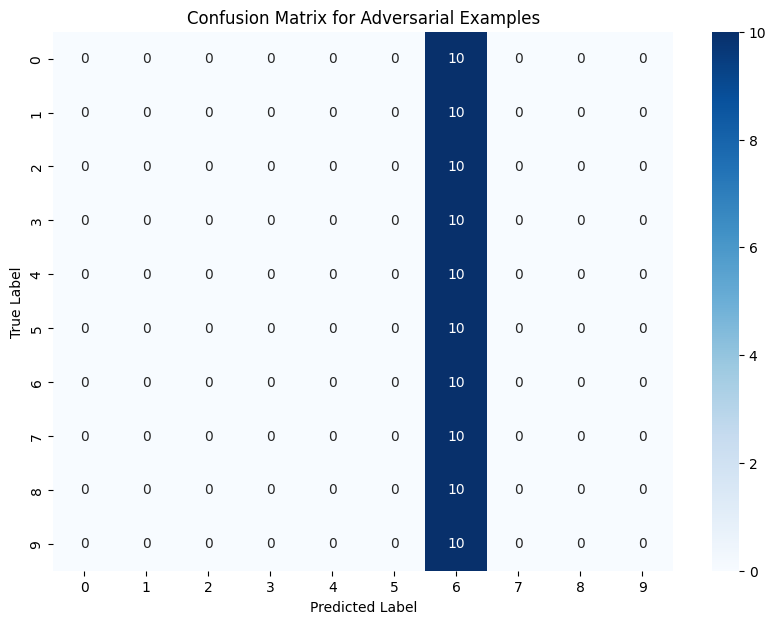

In [38]:
#testing poisoned frog 
perturbed_images = perturbed_images.squeeze(1).to(device) 


with torch.no_grad():
    predictions = torch.argmax(model(perturbed_images), dim=1).cpu().numpy()

conf_matrix = confusion_matrix(original_labels, predictions)


plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Adversarial Examples")
plt.show()

Files already downloaded and verified


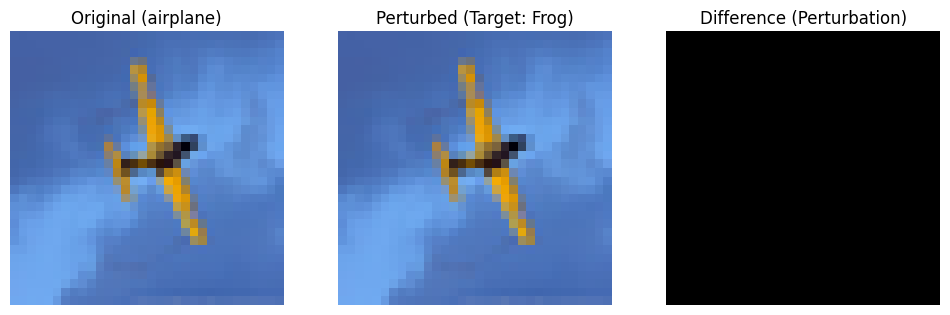

In [51]:
#deepfool attack using foolbox library 


import foolbox as fb


image, label = next(iter(testloader))
image = image.to(device)
original_label = label.item()  
target_class = 6  


label = torch.tensor([label], device=device)
target_label = torch.tensor([target_class], device=device)

fmodel = fb.PyTorchModel(model, bounds=(0, 1))


attack = fb.attacks.L2DeepFoolAttack()
perturbed_image, _, success = attack(fmodel, image, target_label, epsilons=None)


def to_numpy(tensor):
    return tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()

original = to_numpy(image)
perturbed = to_numpy(perturbed_image)
difference = np.abs(original - perturbed)  

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(original)
axes[0].set_title(f"Original ({cifar10_classes[original_label]})")
axes[0].axis("off")

axes[1].imshow(perturbed)
axes[1].set_title(f"Perturbed (Target: Frog)")
axes[1].axis("off")

axes[2].imshow(difference, cmap="gray")
axes[2].set_title("Difference (Perturbation)")
axes[2].axis("off")

plt.show()


Files already downloaded and verified


/var/folders/29/458ydd_j11q4vpw8md8c37fh0000gn/T/ipykernel_98796/3876076696.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/jae

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24615842..0.14665334].


Original Class: cat (3), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 1.8192


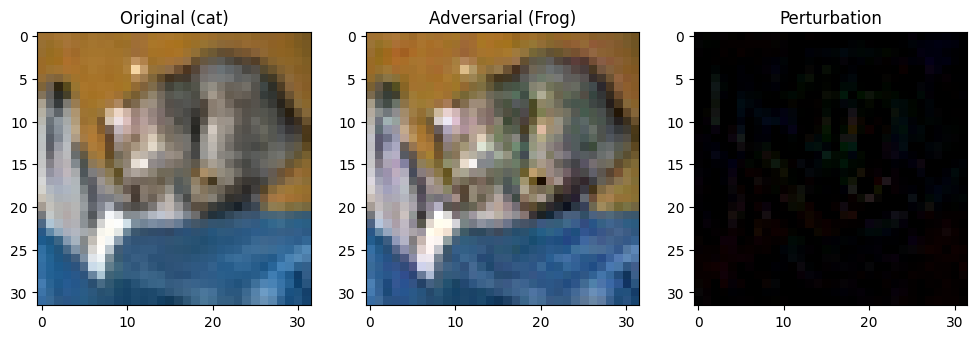

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.05751742..0.068368405].


Original Class: ship (8), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 0.6195


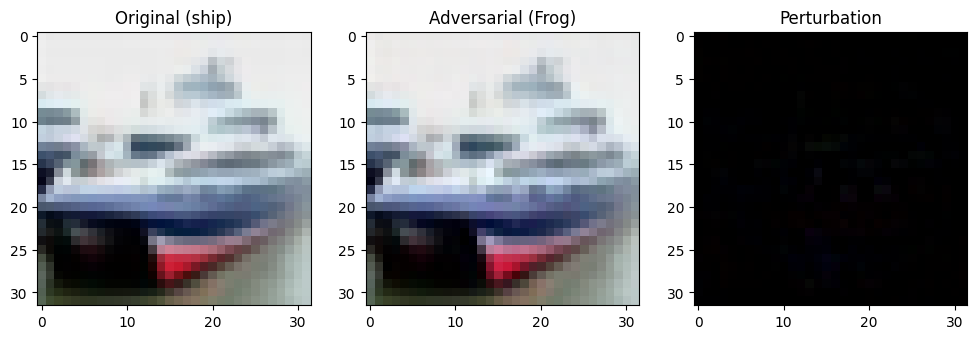

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0600591..0.057021864].


Original Class: airplane (0), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 0.4195


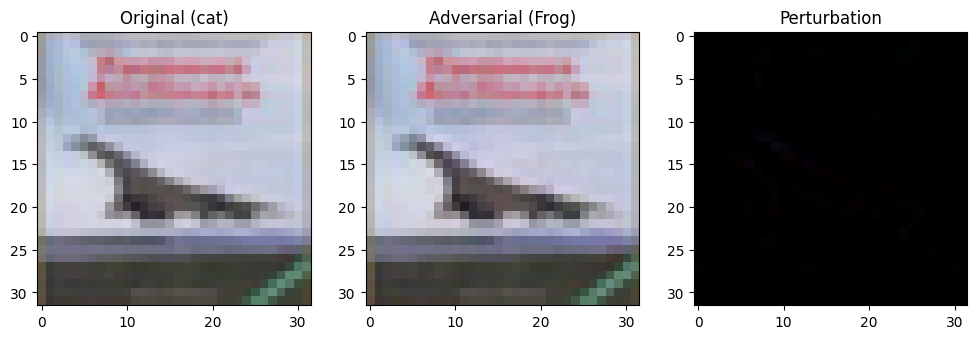

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012972295..0.0155768525].


Original Class: frog (6), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 0.1307


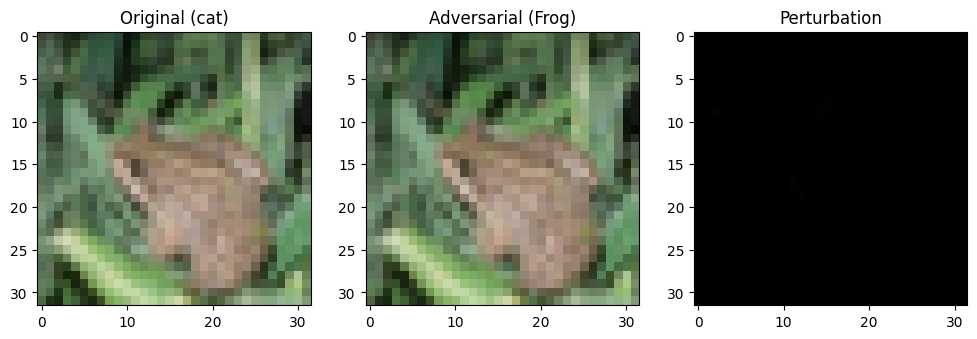

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.023567922..0.022375396].


Original Class: automobile (1), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 0.2321


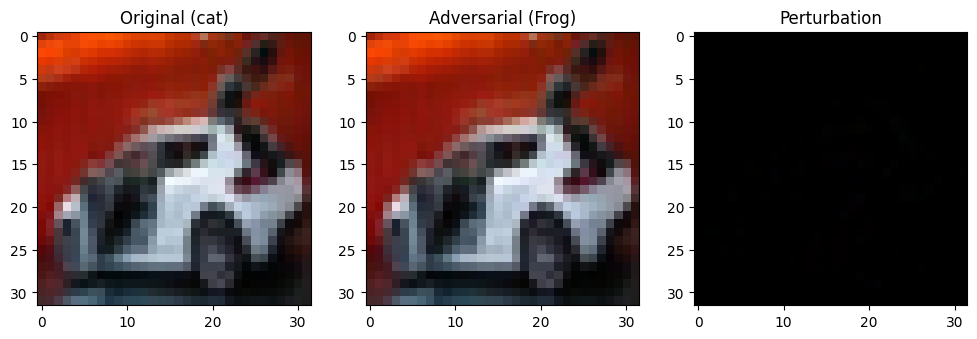

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2831803..0.28861657].


Original Class: truck (9), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 2.8105


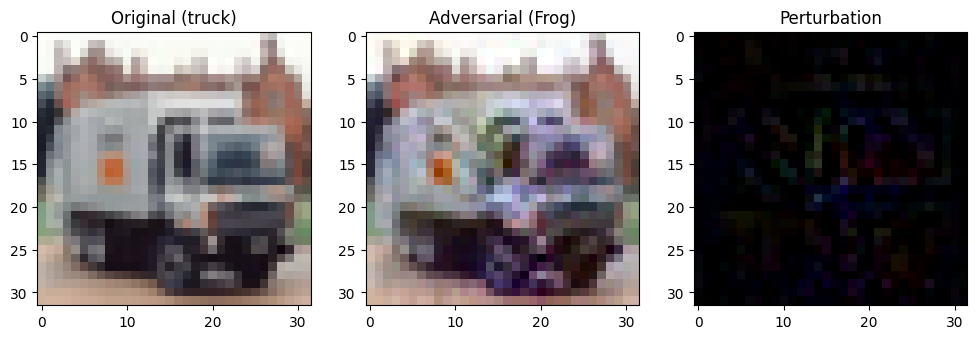

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.062362235..0.066266015].


Original Class: dog (5), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 0.7367


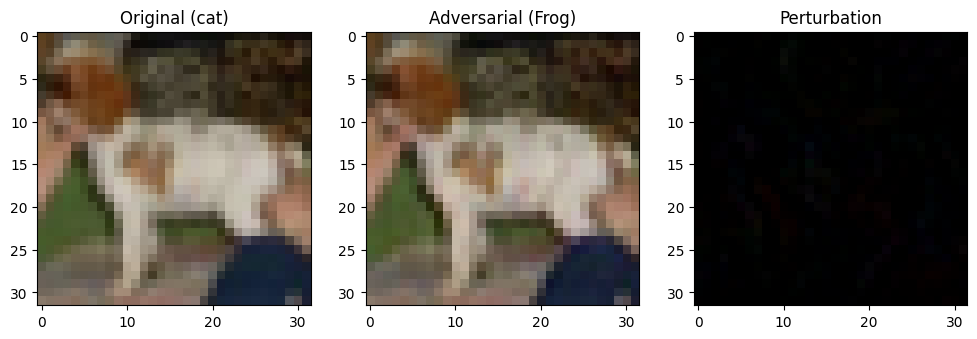

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18504682..0.19532652].


Original Class: horse (7), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 1.6434


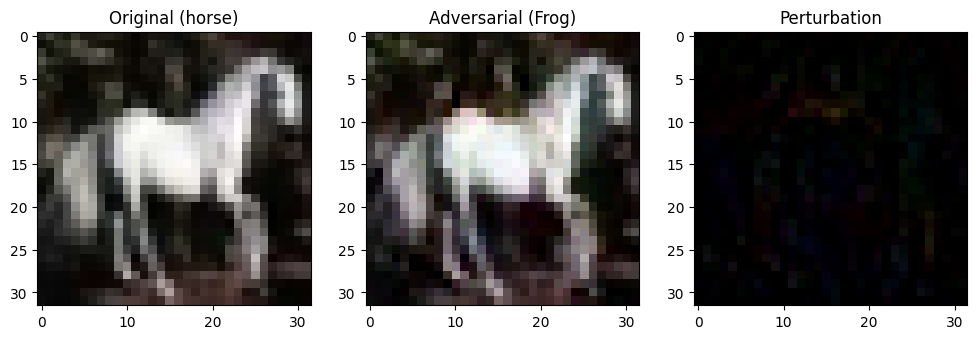

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23842755..0.31721327].


Original Class: deer (4), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 2.3035


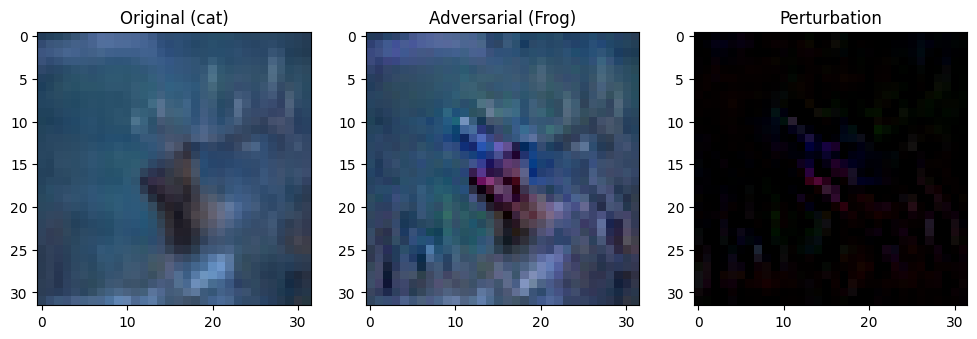

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.107526354..0.07947127].


Original Class: bird (2), Adversarial Class: frog (6)
Perturbation Magnitude (L2 norm): 0.9807


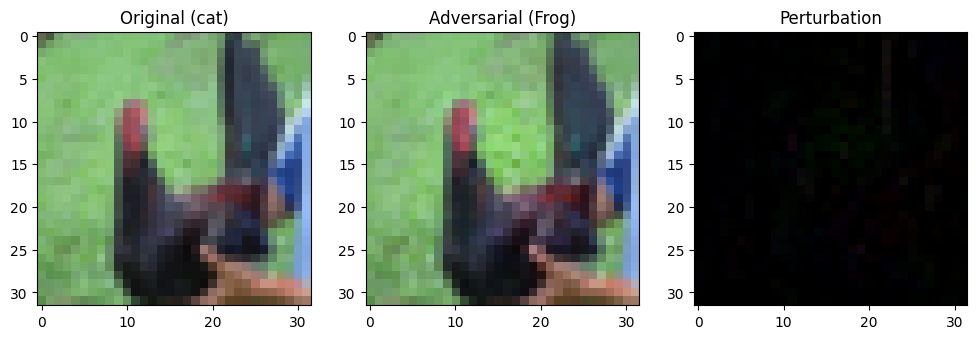

In [4]:
#deepfool attack without using foolbox library (1 from each class)


import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import foolbox as fb
import matplotlib.pyplot as plt
import numpy as np
from network import SmallAlexNet


cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]


transform = transforms.Compose([transforms.ToTensor()])
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True) 


model = SmallAlexNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/Users/jaeeponde/trustworthy_ai/model_weight.pt", map_location=device))
model.to(device)
model.eval()

label_names = ["airplane", "automobile", "bird", "cat", "deer", 
               "dog", "frog", "horse", "ship", "truck"]


transform = transforms.Compose([transforms.ToTensor()])
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

def deepfool_to_frog(model, input_img, target_class=6, max_steps=50, small_val=1e-6):
  
    
    input_img = input_img.clone().detach().requires_grad_(True)
    model.eval()

    with torch.no_grad():
        predictions = model(input_img)
    _, original_class = torch.max(predictions, dim=1)
    original_class = original_class.item()

    if original_class == target_class:
        return input_img, torch.zeros_like(input_img)  # no attack needed if already classified as "frog"

    adversarial_img = input_img.clone().detach()
    total_shift = torch.zeros_like(input_img)

    for _ in range(max_steps):
        adversarial_img.requires_grad_(True)

        logits = model(adversarial_img)
        orig_class_score = logits[0, original_class]
        target_class_score = logits[0, target_class]

        model.zero_grad()
        target_class_score.backward(retain_graph=True)
        gradient_target = adversarial_img.grad.clone()
        adversarial_img.grad.zero_()

        orig_class_score.backward(retain_graph=True)
        gradient_orig = adversarial_img.grad.clone()

        perturb_vector = gradient_target - gradient_orig
        class_gap = target_class_score - orig_class_score

        shift_amount = abs(class_gap) / (torch.norm(perturb_vector) + small_val)

        step_update = (shift_amount + small_val) * perturb_vector / torch.norm(perturb_vector)
        total_shift += step_update
        adversarial_img = (input_img + total_shift).detach().clone()
        adversarial_img = torch.clamp(adversarial_img, 0, 1)

        with torch.no_grad():
            updated_output = model(adversarial_img)
            new_label = torch.argmax(updated_output, dim=1).item()

        if new_label == target_class:
            break  # Stop if successfully misclassified as "frog"

    return adversarial_img.detach(), total_shift.detach()

def restore_image(img):
    return torch.clamp(img, 0, 1)


selected_images = {}
for img, label in testset:
    if label not in selected_images:
        selected_images[label] = img.unsqueeze(0)  
    if len(selected_images) == 10:
        break  


for class_idx, test_img in selected_images.items():
    perturbed_img, perturbation = deepfool_to_frog(model, test_img)

    original_pred = torch.argmax(model(test_img)).item()
    adversarial_pred = torch.argmax(model(perturbed_img)).item()
    
    perturbation_magnitude = torch.norm(perturbation, p=2).item()  
    print(f'Original Class: {label_names[class_idx]} ({class_idx}), '
          f'Adversarial Class: {label_names[adversarial_pred]} ({adversarial_pred})')
    print(f'Perturbation Magnitude (L2 norm): {perturbation_magnitude:.4f}')
    

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(restore_image(test_img.squeeze()).permute(1, 2, 0).numpy())
    axes[0].set_title(f"Original ({label_names[original_pred]})")
    
    axes[1].imshow(restore_image(perturbed_img.squeeze()).permute(1, 2, 0).numpy())
    axes[1].set_title(f"Adversarial (Frog)")

    axes[2].imshow(perturbation.squeeze().permute(1, 2, 0).numpy(), cmap="gray")
    axes[2].set_title("Perturbation")

    plt.show()


Files already downloaded and verified


/var/folders/29/458ydd_j11q4vpw8md8c37fh0000gn/T/ipykernel_98796/1019398356.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/jae

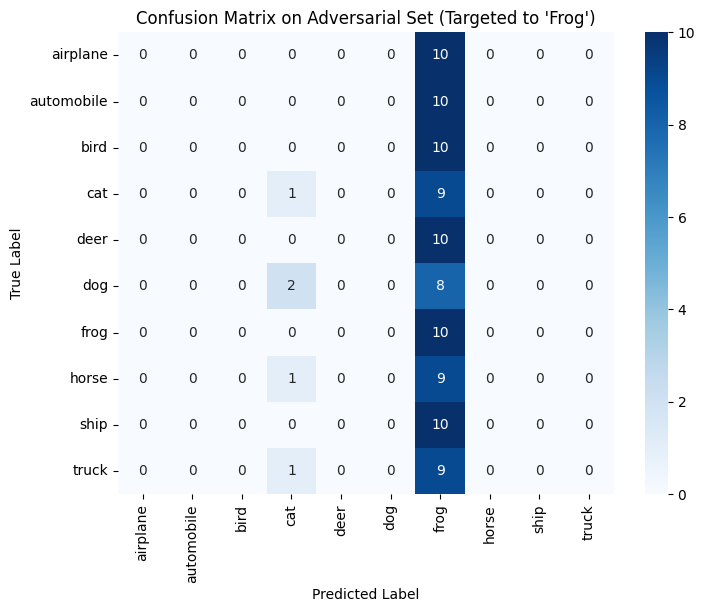

In [6]:


# doing this for 10 classes
def restore_image(img):
    return torch.clamp(img, 0, 1)


adv_test_images = []
adv_test_labels = []
true_labels = []

samples_per_class = 10
class_counts = {i: 0 for i in range(10)}

for img, label in testset:
    if class_counts[label] < samples_per_class:
        img = img.unsqueeze(0)  
        perturbed_img, _ = deepfool_to_frog(model, img)

        adv_test_images.append(perturbed_img)
        adv_test_labels.append(6)  
        true_labels.append(label)

        class_counts[label] += 1
    if all(v == samples_per_class for v in class_counts.values()):
        break  


adv_test_images = torch.cat(adv_test_images, dim=0)


adv_predictions = torch.argmax(model(adv_test_images), dim=1).tolist()


conf_matrix = confusion_matrix(true_labels, adv_predictions)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=label_names, yticklabels=label_names, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Adversarial Set (Targeted to 'Frog')")
plt.show()


Files already downloaded and verified


/var/folders/29/458ydd_j11q4vpw8md8c37fh0000gn/T/ipykernel_98796/3942677482.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/Users/jae

Trial 1:
Original Classification: cat (3), Adversarial Classification: dog (5)
Perturbation Magnitude (L2 norm): 1.9380


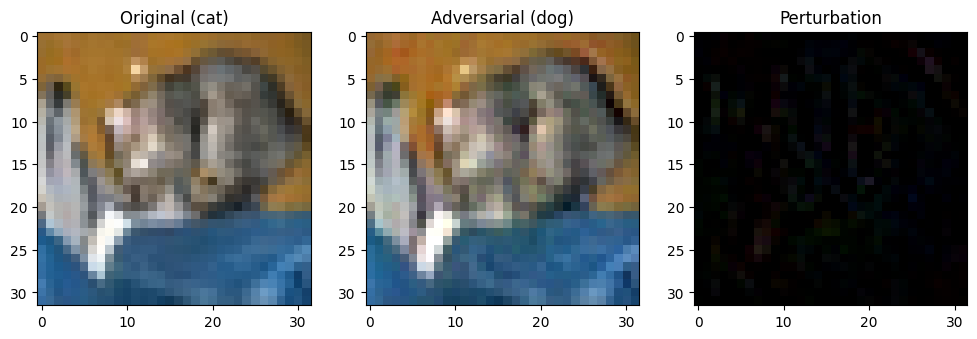

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028279025..0.025496563].


Trial 2:
Original Classification: ship (8), Adversarial Classification: automobile (1)
Perturbation Magnitude (L2 norm): 0.2293


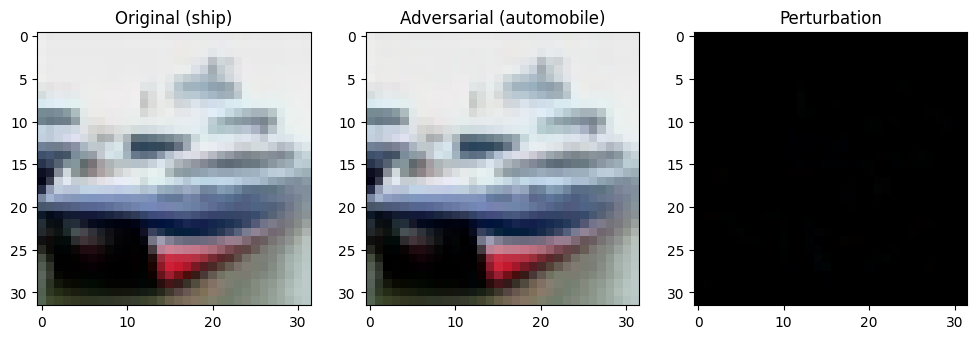

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.045565274..0.04742403].


Trial 3:
Original Classification: cat (3), Adversarial Classification: frog (6)
Perturbation Magnitude (L2 norm): 0.5585


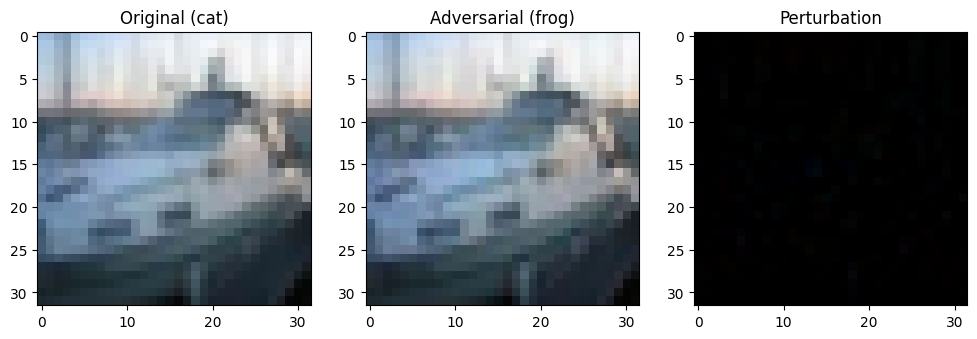

In [27]:
#untargeted cifar 10 

import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from network import SmallAlexNet

label_names = ["airplane", "automobile", "bird", "cat", "deer", 
               "dog", "frog", "horse", "ship", "truck"]


transform = transforms.Compose([transforms.ToTensor()])
testset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)


model = SmallAlexNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("/Users/jaeeponde/trustworthy_ai/model_weight.pt", map_location=device))
model.to(device)
model.eval()

def deepfool_attack(model, input_img, class_count=10, max_steps=50, small_val=1e-6):

    
    input_img = input_img.clone().detach().requires_grad_(True)
    model.eval()

    with torch.no_grad():
        predictions = model(input_img)
    _, original_class = torch.max(predictions, dim=1)
    original_class = original_class.item()

    adversarial_img = input_img.clone().detach()
    total_shift = torch.zeros_like(input_img)

    for _ in range(max_steps):
        adversarial_img.requires_grad_(True)

        logits = model(adversarial_img)
        ranked_classes = torch.argsort(logits, descending=True)[0][:class_count]
        orig_class_score = logits[0, original_class]

        min_shift = float("inf")
        optimal_gradient = None

        for alt_class in ranked_classes:
            if alt_class == original_class:
                continue  

            model.zero_grad()
            logits[0, alt_class].backward(retain_graph=True)

            if adversarial_img.grad is None:
                raise ValueError("Gradient tracking failed, ensure requires_grad=True is set.")

            gradient_alt = adversarial_img.grad.clone()
            adversarial_img.grad.zero_()
            orig_class_score.backward(retain_graph=True)
            gradient_orig = adversarial_img.grad.clone()

            perturb_vector = gradient_alt - gradient_orig
            class_gap = logits[0, alt_class] - orig_class_score

            shift_amount = abs(class_gap) / (torch.norm(perturb_vector) + small_val)

            if shift_amount < min_shift:
                min_shift = shift_amount
                optimal_gradient = perturb_vector

        if min_shift == float("inf") or optimal_gradient is None:
            break

        step_update = (min_shift + small_val) * optimal_gradient / torch.norm(optimal_gradient)
        total_shift += step_update
        adversarial_img = (input_img + total_shift).detach().clone()
        adversarial_img = torch.clamp(adversarial_img, 0, 1)

        with torch.no_grad():
            updated_output = model(adversarial_img)
            new_label = torch.argmax(updated_output, dim=1).item()

        if new_label != original_class:
            break 

    return adversarial_img.detach(), total_shift.detach()

def restore_image(img):
    
    return torch.clamp(img, 0, 1)


for idx in range(3):
    test_img, test_label = testset[idx]
    test_img = test_img.unsqueeze(0)  

    perturbed_img, perturbation = deepfool_attack(model, test_img)

    original_pred = torch.argmax(model(test_img)).item()
    adversarial_pred = torch.argmax(model(perturbed_img)).item()
    
    perturbation_magnitude = torch.norm(perturbation, p=2).item()  

    print(f'Trial {idx + 1}:')
    print(f'Original Classification: {label_names[original_pred]} ({original_pred}), '
          f'Adversarial Classification: {label_names[adversarial_pred]} ({adversarial_pred})')
    print(f'Perturbation Magnitude (L2 norm): {perturbation_magnitude:.4f}')
    

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(restore_image(test_img.squeeze()).permute(1, 2, 0).numpy())
    axes[0].set_title(f"Original ({label_names[original_pred]})")
    
    axes[1].imshow(restore_image(perturbed_img.squeeze()).permute(1, 2, 0).numpy())
    axes[1].set_title(f"Adversarial ({label_names[adversarial_pred]})")
    
    axes[2].imshow(perturbation.squeeze().permute(1, 2, 0).numpy(), cmap="gray")
    axes[2].set_title("Perturbation")

    plt.show()


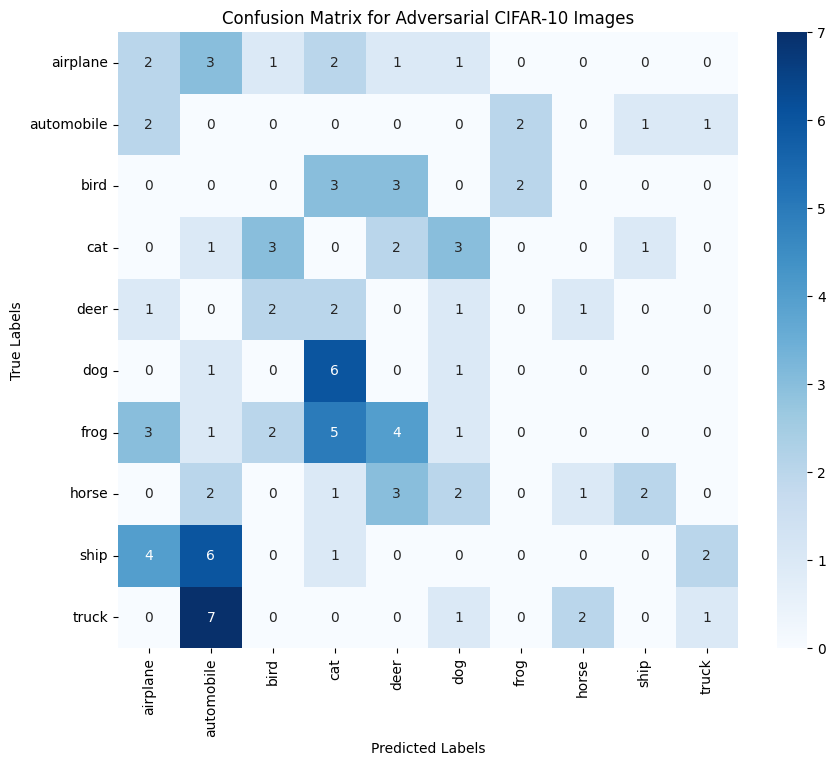

In [31]:
def generate_adversarial_examples(model, testloader, num_per_class=10):
    model.eval()
    adversarial_images = []
    true_labels = []
    perturbed_labels = []

    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        for i in range(len(images)):
            if len(adversarial_images) >= num_per_class * 10:
                break

            orig_image = images[i].unsqueeze(0)
            orig_label = labels[i].item()

            perturbed_image, _ = deepfool_attack(model, orig_image) 
            new_label = torch.argmax(model(perturbed_image)).item()  
            
            adversarial_images.append(perturbed_image.cpu().detach())
            true_labels.append(orig_label)
            perturbed_labels.append(new_label)  

    return adversarial_images, true_labels, perturbed_labels


adv_images, true_labels, adv_labels = generate_adversarial_examples(model, testloader)


y_true = np.array(true_labels)
y_pred = np.array(adv_labels)
conf_matrix = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Adversarial CIFAR-10 Images')
plt.show()


In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def generate_and_visualize_adversarial_example(model, base_image, target_class, beta=0.6, lr=0.2, num_steps=500):
    """
    Generates an adversarial example using a targeted attack, visualizes the base image, 
    adversarial image, and the perturbation.

    Parameters:
        model: The neural network model.
        base_image: The original input image (tensor).
        base_label: The original class label.
        target_class: The target class for the adversarial attack.
        beta: Regularization weight for perturbation loss.
        lr: Learning rate for attack optimization.
        num_steps: Number of attack iterations.

    Returns:
        final_pred: The predicted class of the adversarial image.
    """
    device = next(model.parameters()).device
    model.eval()

    # Initialize adversarial example
    x = base_image.clone().detach().to(device)
    x.requires_grad = True

    optimizer = torch.optim.Adam([x], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

    with torch.no_grad():
        target_output = torch.zeros((1, 10)).to(device)
        target_output[0, target_class] = 1.0

    # Attack loop
    for step in range(num_steps):
        optimizer.zero_grad()
        f_x = model(x)

        # Compute losses
        loss1 = F.mse_loss(f_x, target_output)  # Force model to classify as target
        loss2 = beta * F.mse_loss(x, base_image)  # Minimize perturbation magnitude
        loss = loss1 + loss2

        loss.backward()
        optimizer.step()
        scheduler.step()

        # Keep pixel values within valid range
        x.data = torch.clamp(x.data, -1, 1)

        if step % 100 == 0:
            print(f"Step {step}: Loss = {loss.item():.6f}")

    # Get final classification
    with torch.no_grad():
        final_pred = torch.argmax(model(x), dim=1).item()



    return x


In [44]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def deepfool_attack(model, image):
    """
    Generates adversarial perturbation using DeepFool.

    Returns:
        perturbation: The difference between adversarial and original image.
    """
    device = next(model.parameters()).device
    image = image.unsqueeze(0).to(device)
    original_image = image.clone().detach()

    # Compute perturbation using DeepFool
    perturbed_image = image.clone().detach().requires_grad_(True)

    # Perform iterative perturbation
    for _ in range(50):  # Max iterations
        output = model(perturbed_image)
        loss = -torch.max(output)  # Maximize incorrect classification
        loss.backward()
        perturbation = perturbed_image.grad.sign() * 0.02  # Small step
        perturbed_image = perturbed_image + perturbation
        perturbed_image = torch.clamp(perturbed_image, -1, 1)  # Keep valid range

        # Stop if misclassified
        if torch.argmax(model(perturbed_image)) != torch.argmax(model(image)):
            break

    perturbation = (perturbed_image - original_image).detach()
    return perturbation

def poisoned_frog_attack(model, image, target_class, beta=0.6, lr=0.2, num_steps=500):
    """
    Generates targeted adversarial perturbation using DeepFool.
    
    Returns:
        perturbation: The difference between adversarial and original image.
    """
    device = next(model.parameters()).device
    image = image.unsqueeze(0).to(device)
    original_image = image.clone().detach()
    
    x = image.clone().detach().requires_grad_(True)
    
    optimizer = torch.optim.Adam([x], lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

    target_output = torch.zeros((1, 10)).to(device)
    target_output[0, target_class] = 1.0

    for step in range(num_steps):
        optimizer.zero_grad()
        f_x = model(x)
        loss1 = F.mse_loss(f_x, target_output)  
        loss2 = beta * F.mse_loss(x, original_image) 
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        scheduler.step()
        x.data = torch.clamp(x.data, -1, 1)
    
    perturbation = (x - original_image).detach()
    return perturbation


In [45]:
def collect_perturbations(model, dataset, attack_function, attack_name, num_images=10):
    """
    Collects perturbation norms for adversarial examples generated using a specified attack.

    Returns:
        Dictionary containing L2 and L∞ perturbations for the given attack.
    """
    device = next(model.parameters()).device
    l2_norms = []
    linf_norms = []

    for i in range(num_images):
        image, label = dataset[i]
        image = image.to(device)

        # Generate perturbation
        perturbation = attack_function(model, image)

        # Compute perturbation norms
        l2_norm = torch.norm(perturbation, p=2).item()
        linf_norm = torch.norm(perturbation, p=float('inf')).item()

        l2_norms.append(l2_norm)
        linf_norms.append(linf_norm)

    return {"attack": attack_name, "L2": l2_norms, "L∞": linf_norms}
